In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


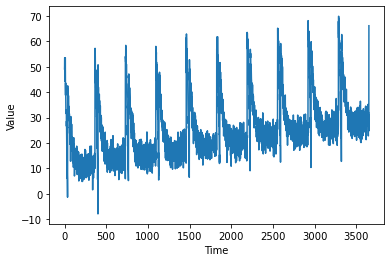

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  # enables arbitrary operations to effectively expand the functionality of TF keras
  # with the lambda function we can alter the setting without using the window helper function

  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # alter the input shape dimension by 1
                         input_shape=[None]), # take any length of sequence
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100) # scale the output by 100 
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), # loss function that is less sensetive to outliers
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 7s 76ms/step - loss: 8.6334 - mae: 9.0221
Epoch 2/100
94/94 [==============================] - 1s 9ms/step - loss: 8.0668 - mae: 8.5407
Epoch 3/100
94/94 [==============================] - 1s 8ms/step - loss: 7.7169 - mae: 8.2034
Epoch 4/100
94/94 [==============================] - 1s 8ms/step - loss: 7.5300 - mae: 7.9855
Epoch 5/100
94/94 [==============================] - 1s 8ms/step - loss: 7.3175 - mae: 7.8284
Epoch 6/100
94/94 [==============================] - 1s 10ms/step - loss: 7.1929 - mae: 7.7112
Epoch 7/100
94/94 [==============================] - 1s 14ms/step - loss: 7.1144 - mae: 7.6132
Epoch 8/100
94/94 [==============================] - 1s 12ms/step - loss: 6.9932 - mae: 7.5238
Epoch 9/100
94/94 [==============================] - 1s 8ms/step - loss: 6.9375 - mae: 7.4375
Epoch 10/100
94/94 [==============================] - 1s 8ms/step - loss: 6.8299 - mae: 7.3491
Epoch 11/100
94/94 [==============================] - 1

94/94 [==============================] - 1s 8ms/step - loss: 3.2558 - mae: 3.7230
Epoch 88/100
94/94 [==============================] - 1s 8ms/step - loss: 3.9340 - mae: 4.4157
Epoch 89/100
94/94 [==============================] - 1s 8ms/step - loss: 3.1715 - mae: 3.6131
Epoch 90/100
94/94 [==============================] - 1s 8ms/step - loss: 3.3833 - mae: 3.8470
Epoch 91/100
94/94 [==============================] - 1s 9ms/step - loss: 3.5575 - mae: 4.0292
Epoch 92/100
94/94 [==============================] - 1s 8ms/step - loss: 3.4946 - mae: 3.9708
Epoch 93/100
94/94 [==============================] - 1s 8ms/step - loss: 3.7122 - mae: 4.2009
Epoch 94/100
94/94 [==============================] - 1s 9ms/step - loss: 3.7806 - mae: 4.2830
Epoch 95/100
94/94 [==============================] - 1s 9ms/step - loss: 3.2205 - mae: 3.6839
Epoch 96/100
94/94 [==============================] - 1s 8ms/step - loss: 3.6728 - mae: 4.1684
Epoch 97/100
94/94 [==============================] - 1s 9ms/st

(1e-08, 0.0001, 0.0, 30.0)

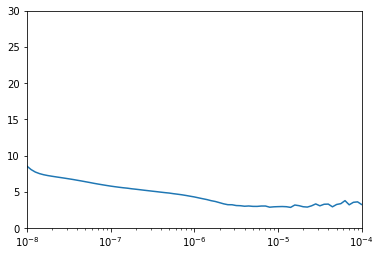

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
    input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=9*1e-6, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/500
94/94 [==============================] - 7s 70ms/step - loss: 179.9796 - mae: 9.2085s: 222.0980 - 6s 93ms/step - l
Epoch 2/500
94/94 [==============================] - 1s 10ms/step - loss: 97.2143 - mae: 6.7677
Epoch 3/500
94/94 [==============================] - 1s 9ms/step - loss: 86.8957 - mae: 6.3152
Epoch 4/500
94/94 [==============================] - 1s 9ms/step - loss: 78.5786 - mae: 5.7770
Epoch 5/500
94/94 [==============================] - 1s 9ms/step - loss: 72.7197 - mae: 5.4442
Epoch 6/500
94/94 [==============================] - 1s 8ms/step - loss: 68.5917 - mae: 5.2529
Epoch 7/500
94/94 [==============================] - 1s 8ms/step - loss: 65.4305 - mae: 5.1391
Epoch 8/500
94/94 [==============================] - 1s 8ms/step - loss: 61.7122 - mae: 4.9460
Epoch 9/500
94/94 [==============================] - 1s 8ms/step - loss: 61.1325 - mae: 5.0029
Epoch 10/500
94/94 [==============================] - 1s 8ms/step - loss: 59.6487 - mae: 4.9385
Epoch 11/500
94/

94/94 [==============================] - 1s 8ms/step - loss: 27.3375 - mae: 3.4666
Epoch 87/500
94/94 [==============================] - 1s 8ms/step - loss: 28.0582 - mae: 3.5630
Epoch 88/500
94/94 [==============================] - 1s 8ms/step - loss: 26.1849 - mae: 3.4586
Epoch 89/500
94/94 [==============================] - 1s 8ms/step - loss: 25.3505 - mae: 3.3833
Epoch 90/500
94/94 [==============================] - 1s 8ms/step - loss: 26.1572 - mae: 3.4551
Epoch 91/500
94/94 [==============================] - 1s 8ms/step - loss: 25.7784 - mae: 3.3924
Epoch 92/500
94/94 [==============================] - 1s 8ms/step - loss: 25.8943 - mae: 3.4253
Epoch 93/500
94/94 [==============================] - 1s 8ms/step - loss: 26.8609 - mae: 3.5432
Epoch 94/500
94/94 [==============================] - 1s 8ms/step - loss: 27.4606 - mae: 3.5922
Epoch 95/500
94/94 [==============================] - 1s 8ms/step - loss: 27.6760 - mae: 3.5600
Epoch 96/500
94/94 [==============================] -

94/94 [==============================] - 1s 8ms/step - loss: 26.0891 - mae: 3.4461
Epoch 171/500
94/94 [==============================] - 1s 8ms/step - loss: 25.7717 - mae: 3.4124
Epoch 172/500
94/94 [==============================] - 1s 8ms/step - loss: 25.9685 - mae: 3.4019
Epoch 173/500
94/94 [==============================] - 1s 9ms/step - loss: 26.0510 - mae: 3.4245
Epoch 174/500
94/94 [==============================] - 1s 10ms/step - loss: 25.6812 - mae: 3.4077
Epoch 175/500
94/94 [==============================] - 1s 9ms/step - loss: 25.5674 - mae: 3.4200
Epoch 176/500
94/94 [==============================] - 1s 9ms/step - loss: 24.4982 - mae: 3.3032
Epoch 177/500
94/94 [==============================] - 1s 10ms/step - loss: 25.5863 - mae: 3.4134
Epoch 178/500
94/94 [==============================] - 1s 9ms/step - loss: 26.0188 - mae: 3.4555
Epoch 179/500
94/94 [==============================] - 1s 8ms/step - loss: 26.5795 - mae: 3.4811
Epoch 180/500
94/94 [=====================

94/94 [==============================] - 1s 8ms/step - loss: 23.4545 - mae: 3.2404
Epoch 255/500
94/94 [==============================] - 1s 8ms/step - loss: 22.7231 - mae: 3.2093
Epoch 256/500
94/94 [==============================] - 1s 8ms/step - loss: 23.1821 - mae: 3.2613
Epoch 257/500
94/94 [==============================] - 1s 8ms/step - loss: 22.8619 - mae: 3.2180
Epoch 258/500
94/94 [==============================] - 1s 8ms/step - loss: 22.8499 - mae: 3.2189
Epoch 259/500
94/94 [==============================] - 1s 8ms/step - loss: 23.5896 - mae: 3.1764
Epoch 260/500
94/94 [==============================] - 1s 8ms/step - loss: 23.8185 - mae: 3.3144
Epoch 261/500
94/94 [==============================] - 1s 8ms/step - loss: 23.4947 - mae: 3.2937
Epoch 262/500
94/94 [==============================] - 1s 8ms/step - loss: 23.2439 - mae: 3.2637
Epoch 263/500
94/94 [==============================] - 1s 8ms/step - loss: 22.5964 - mae: 3.1944
Epoch 264/500
94/94 [=======================

94/94 [==============================] - 1s 8ms/step - loss: 21.7903 - mae: 3.1236
Epoch 339/500
94/94 [==============================] - 1s 8ms/step - loss: 21.0046 - mae: 3.0468
Epoch 340/500
94/94 [==============================] - 1s 8ms/step - loss: 21.8042 - mae: 3.1275
Epoch 341/500
94/94 [==============================] - 1s 8ms/step - loss: 21.4650 - mae: 3.1052
Epoch 342/500
94/94 [==============================] - 1s 8ms/step - loss: 21.2713 - mae: 3.0890
Epoch 343/500
94/94 [==============================] - 1s 8ms/step - loss: 21.0372 - mae: 3.0628
Epoch 344/500
94/94 [==============================] - 1s 8ms/step - loss: 22.3891 - mae: 3.2049
Epoch 345/500
94/94 [==============================] - 1s 8ms/step - loss: 21.7180 - mae: 3.1314
Epoch 346/500
94/94 [==============================] - 1s 8ms/step - loss: 21.5918 - mae: 3.0965
Epoch 347/500
94/94 [==============================] - 1s 8ms/step - loss: 22.2463 - mae: 3.0782
Epoch 348/500
94/94 [=======================

94/94 [==============================] - 1s 8ms/step - loss: 21.1074 - mae: 3.0852
Epoch 423/500
94/94 [==============================] - 1s 8ms/step - loss: 20.4771 - mae: 3.0161
Epoch 424/500
94/94 [==============================] - 1s 8ms/step - loss: 21.2719 - mae: 3.0851
Epoch 425/500
94/94 [==============================] - 1s 8ms/step - loss: 21.1394 - mae: 3.1060
Epoch 426/500
94/94 [==============================] - 1s 8ms/step - loss: 21.1533 - mae: 3.0960
Epoch 427/500
94/94 [==============================] - 1s 8ms/step - loss: 21.0619 - mae: 3.0756
Epoch 428/500
94/94 [==============================] - 1s 8ms/step - loss: 21.1623 - mae: 3.0983
Epoch 429/500
94/94 [==============================] - 1s 8ms/step - loss: 22.4047 - mae: 3.2095
Epoch 430/500
94/94 [==============================] - 1s 8ms/step - loss: 21.0631 - mae: 3.0750
Epoch 431/500
94/94 [==============================] - 1s 8ms/step - loss: 21.0475 - mae: 3.0676
Epoch 432/500
94/94 [=======================

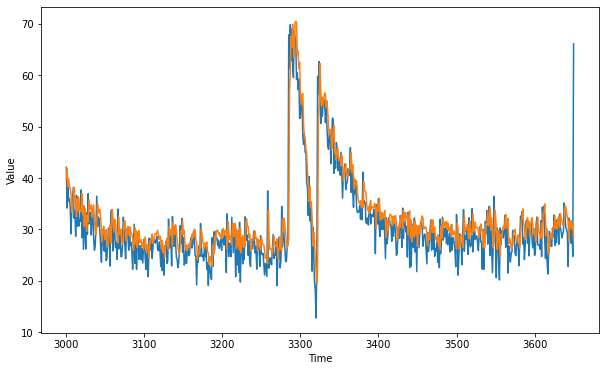

In [18]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

3.478048

<Figure size 432x288 with 0 Axes>

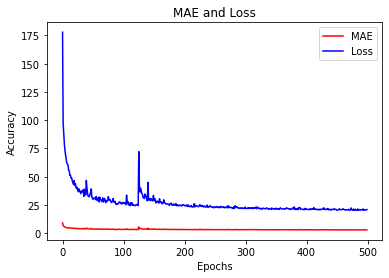

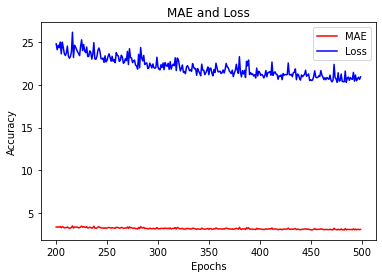

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()